# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [167]:
# Importing libraries

import pandas as pd
import numpy as np

import re 
from scipy import stats
from scipy.stats import skew 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
import statsmodels.stats.api as sms

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score #, make_scorer
from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [168]:
# Reading data from csv file

data = pd.read_csv('data/vehicles.csv')

In [169]:
# Checking the first five rows of a dataset

data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [170]:
# Checking dataset information

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [171]:
# Checking null values in the dataset

pd.DataFrame(np.round(data.isnull().mean() * 100, 2), columns = ['% missing values']).astype(str) + ' %'

,% missing values
id,0.0 %
region,0.0 %
price,0.0 %
year,0.28 %
manufacturer,4.13 %
model,1.24 %
condition,40.79 %
cylinders,41.62 %
fuel,0.71 %
odometer,1.03 %


In [172]:
# Checking duplicate values in the dataset

data[data.duplicated()]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state


In [173]:
# Summary statistics of the dataset, including all data types

data.describe(include = 'all')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
count,4.268800e+05,426880,4.268800e+05,425675.000000,409234,421603,252776,249202,423867,4.224800e+05,418638,424324,265838,296313,120519,334022,296677,426880
unique,NaN,404,NaN,NaN,42,29649,6,8,5,NaN,6,3,118246,3,4,13,12,51
top,NaN,columbus,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,NaN,3608,NaN,NaN,70985,8009,121456,94169,356209,NaN,405117,336524,261,131904,63465,87056,79285,50614
mean,7.311487e+09,NaN,7.519903e+04,2011.235191,NaN,NaN,NaN,NaN,NaN,9.804333e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.473170e+06,NaN,1.218228e+07,9.452120,NaN,NaN,NaN,NaN,NaN,2.138815e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.207408e+09,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.308143e+09,NaN,5.900000e+03,2008.000000,NaN,NaN,NaN,NaN,NaN,3.770400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7.312621e+09,NaN,1.395000e+04,2013.000000,NaN,NaN,NaN,NaN,NaN,8.554800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.315254e+09,NaN,2.648575e+04,2017.000000,NaN,NaN,NaN,NaN,NaN,1.335425e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
# We can also see that the minimum value for price and odometer of a car is 0 dollars which does not make sense.
#  For numerical columns a high standard deviation suggests that the data points are widely spread from the mean, 
# It can be an indicator of potential outliers since the spread is unusually large.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [175]:
# filling missing values with 'unknown' for cateogrical columns

categories = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']

for column in categories:
    data[column] = data[column].fillna('unknown')

In [176]:
# Remove records that have price and odometer values less than or equal to zero.

data = data[(data.price > 0) & (data.odometer > 0)]

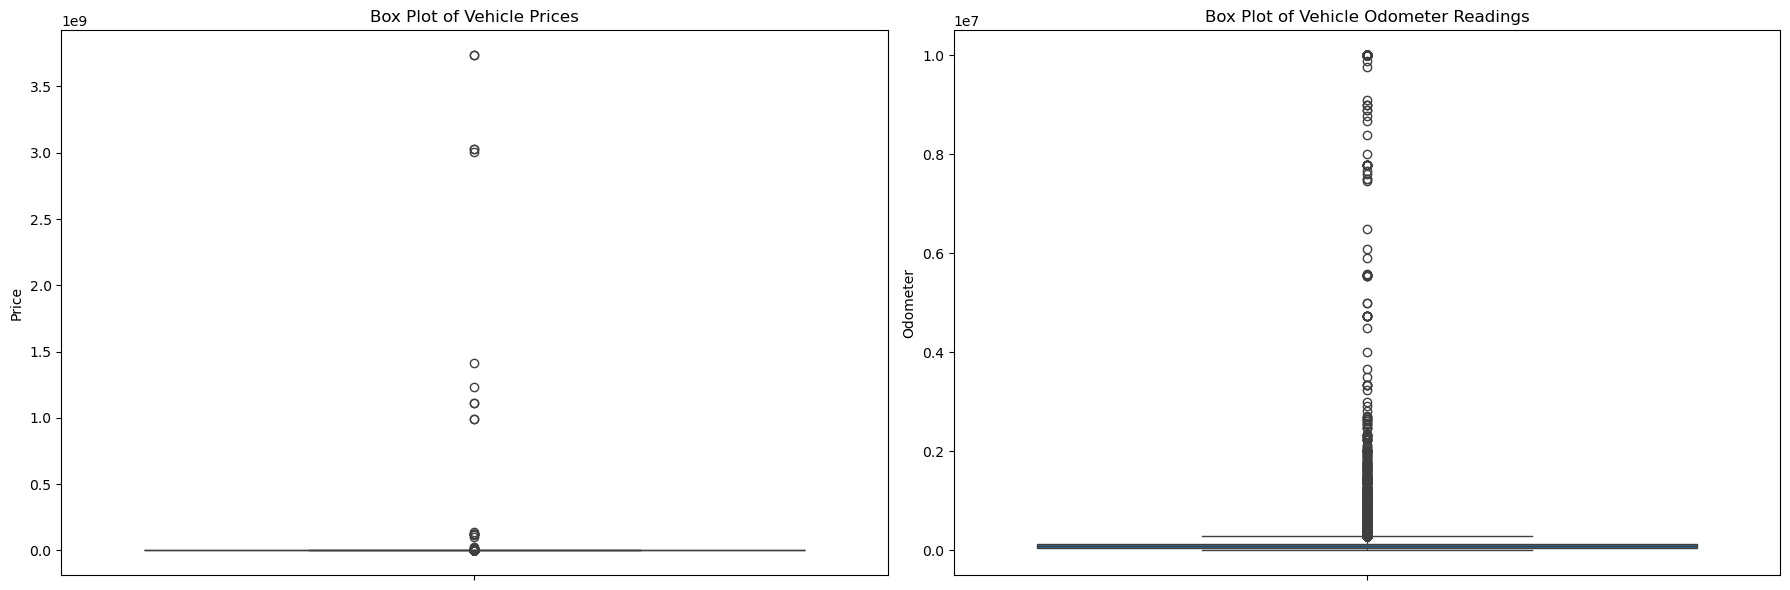

In [177]:
# Check for outliers in odometer and price columns

plt.figure(figsize = (18, 6))

# Box plot for price

plt.subplot(1, 2, 1)
sns.boxplot(y = data.price)
plt.title('Box Plot of Vehicle Prices')
plt.ylabel('Price')

# Box plot for odometer

plt.subplot(1, 2, 2)
sns.boxplot(y = data.odometer)
plt.title('Box Plot of Vehicle Odometer Readings')
plt.ylabel('Odometer')


plt.tight_layout()
plt.show()

In [178]:
# We will remove the outliers by using the IQR method

# Defining a function to remove outliers

def remove_outliers(data, column, multiplier = 1.5):
    '''
    input: data with outliers - pandas dataframe
    output: outlier removed data - pandas dataframe

    This function removes outliers from the data using the IQR method

    '''

    # Calculate 25th percentile and 75th percentile

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)

    # Calculate IQR

    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    # lower multiplier means more sensitive, identifies more points as outliers

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Remove outliers

    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return data


# Removing outliers from the price column

data = remove_outliers(data, 'price', 1.4)

# Removing outliers from the odometer column

data = remove_outliers(data, 'odometer', 1.4)

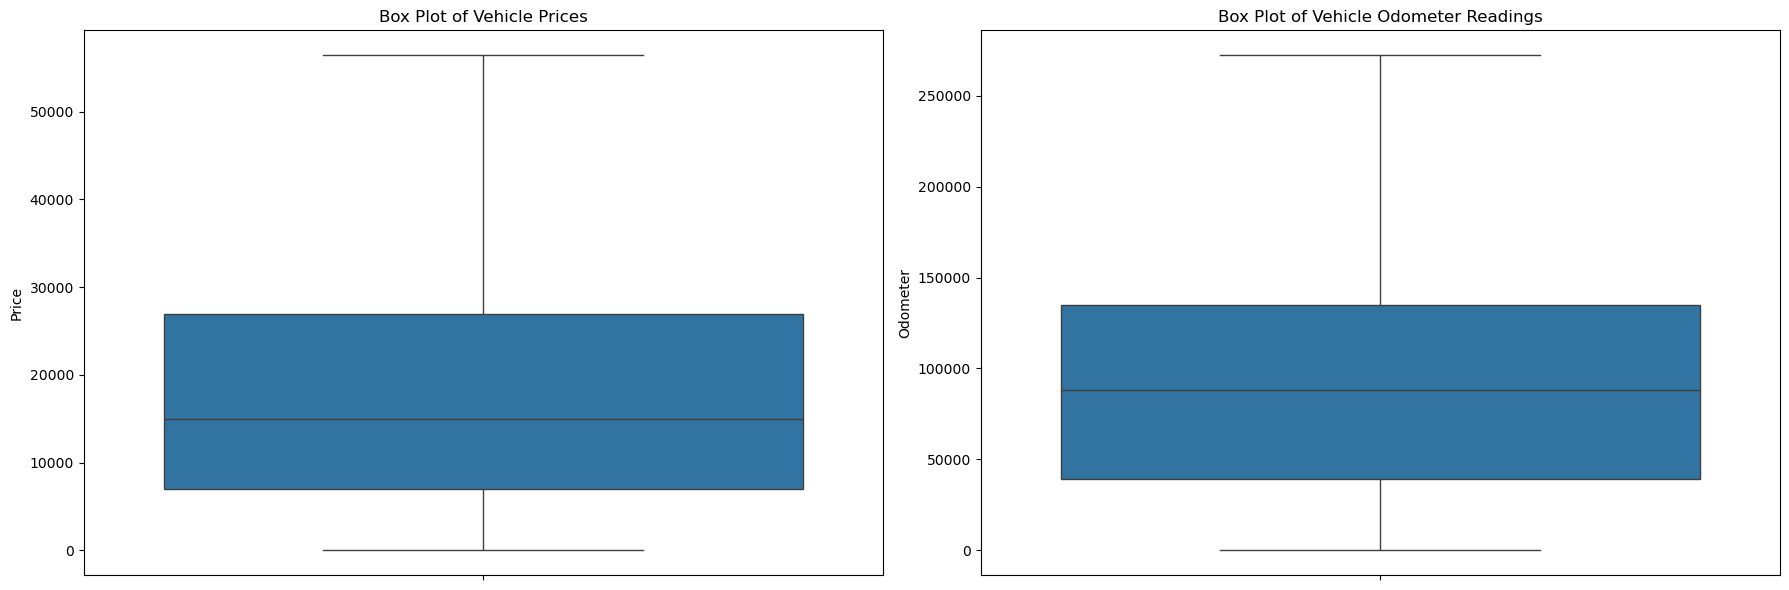

In [179]:
# Verify that the outliers have been removed

plt.figure(figsize = (18, 6))

# Box plot for price

plt.subplot(1, 2, 1)
sns.boxplot(y = data.price)
plt.title('Box Plot of Vehicle Prices')
plt.ylabel('Price')

# Box plot for odometer

plt.subplot(1, 2, 2)
sns.boxplot(y = data.odometer)
plt.title('Box Plot of Vehicle Odometer Readings')
plt.ylabel('Odometer')

# Adjust layout

plt.tight_layout()
plt.show()

In [180]:
# From the box plot above, we can see that we have successfully removed the outliers from the dataset.
# We also see values are closer to zero. Lets check the minimum and maximum values for these two numerical features

print(f"Minimum price of a car in a dataset is", data.price.min())
print(f"Maximum price of a car in a dataset is", data.price.max())

print(f"Minimum odometer reading of a car in a dataset is", data.odometer.min())
print(f"Maximum odometer reading of a car in a dataset is", data.odometer.max())

Minimum price of a car in a dataset is 1
Maximum price of a car in a dataset is 56444
Minimum odometer reading of a car in a dataset is 1.0
Maximum odometer reading of a car in a dataset is 272279.0


In [181]:
# The price of a car of one dollar and odometer reading of 1 does not make sense. We will remove the records that falls below 5th quantile from price and odometer

data = data[(data.price > np.quantile(data.price, 0.05)) & (data.odometer > np.quantile(data.odometer, 0.05))]

In [182]:
# Checking the price and odometer value after filtering out the bottom 5% of the data

print(f"Minimum price of a car in a cleaned dataset is", data.price.min())
print(f"Maximum price of a car in a cleaned dataset is", data.price.max())

print(f"Minimum odometer reading of a car in a cleaned dataset is", data.odometer.min())
print(f"Maximum odometer reading of a car in a cleaned dataset is", data.odometer.max())

Minimum price of a car in a cleaned dataset is 1997
Maximum price of a car in a cleaned dataset is 56409
Minimum odometer reading of a car in a cleaned dataset is 7807.0
Maximum odometer reading of a car in a cleaned dataset is 272279.0


In [183]:
# # data.head()

# # %pip install pyvin
# # %pip install swifter
# # %pip install -U ipywidgets

# import pandas as pd
# import swifter  # Enables parallelized apply
# from pyvin import VIN  

# def decode_vin(vin):
#     try:
#         vehicle = VIN(vin)
#         return vehicle.Make, vehicle.Model, vehicle.ModelYear
#     except ValueError:
#         return None, None, None
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return None, None, None

# # Apply function in parallel
# data[['Make', 'Model', 'Year']] = data['VIN'].swifter.apply(decode_vin).apply(pd.Series)

# print(data)


In [184]:
# Dropping columns that are not useful

data = data.drop(columns = ['id', 'VIN'])


# dropping missing values from the dataset

data = data.dropna()

In [185]:
data.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,unknown,unknown,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,unknown,unknown,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,unknown,unknown,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,unknown,unknown,pickup,red,al
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al


In [285]:
columns = ['condition', 'cylinders', 'fuel', 'title_status', 
           'transmission', 'drive', 'size', 'type', 'paint_color']

for col in columns:
    print(f"Column: {col}")
    print(data[col].value_counts(dropna=False))  # Includes NaN counts
    print("\n" + "="*50 + "\n")

Column: condition
condition
unknown      127907
good         104978
excellent     85833
like new      17164
fair           4021
new             503
salvage         261
Name: count, dtype: int64


Column: cylinders
cylinders
unknown         135687
6 cylinders      78596
4 cylinders      65196
8 cylinders      57372
5 cylinders       1515
10 cylinders      1028
other              727
3 cylinders        427
12 cylinders       119
Name: count, dtype: int64


Column: fuel
fuel
gas         289642
other        23602
diesel       19676
hybrid        4419
unknown       1986
electric      1342
Name: count, dtype: int64


Column: title_status
title_status
clean         323738
rebuilt         6545
unknown         5537
salvage         3211
lien            1245
missing          340
parts only        51
Name: count, dtype: int64


Column: transmission
transmission
automatic    267850
other         52118
manual        19365
unknown        1334
Name: count, dtype: int64


Column: drive
drive
4wd       

In [279]:
# data1 = data[data['title_status'] == 'clean']
# data.manufacturer.unique() --43 unique values
# data.condition.unique() -- 7 unique values
# data.cylinders.unique() -- 8 unique values
# data.fuel.unique() -- 6 unique values
# data.title_status.unique() -- 7 unique values
# data.transmission.unique()
data.drive.unique()

array(['unknown', 'rwd', '4wd', 'fwd'], dtype=object)

In [277]:
data1.describe()

,price,year,odometer
count,1334.000000,1334.000000,1334.000000
mean,19878.814093,2012.488006,99369.117691
std,11942.778140,5.926741,53517.711018
min,2300.000000,1947.000000,7903.000000
25%,10500.000000,2010.000000,58292.750000
50%,16497.500000,2013.000000,96008.000000
75%,27273.000000,2016.000000,131659.500000
max,55999.000000,2021.000000,261591.000000


In [95]:
# We also observed that the model is a a text field, we will extract only the first word from the model name column of the dataset.

def extract_first_word(text: str) -> str:
    """
    Extracts the first word from a given string after removing non-alphanumeric characters.

    Parameters:
    text (str): The input string from which the first word needs to be extracted.

    Returns:
    str: The first word of the cleaned string. Returns an empty string if no word is found.
    """
    # Ensure the input is a string and remove non-alphanumeric characters except spaces

    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    
    # Split the cleaned string by spaces and return the first word (if available)

    first_word = cleaned_text.split()[0] if cleaned_text.strip() else ''
    
    return first_word


# Apply the function to the Model column

data['model'] = data['model'].apply(extract_first_word)

C:\Users\kusha\AppData\Local\Temp\ipykernel_16136\2919850167.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model'] = data['model'].apply(extract_first_word)


In [96]:
data.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
54,auburn,31590,2019.0,cadillac,xt4,good,unknown,other,12102.0,clean,other,fwd,unknown,hatchback,black,al
59,auburn,14000,2012.0,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al
74,auburn,26590,2020.0,honda,civic,good,unknown,gas,9954.0,clean,other,fwd,unknown,coupe,silver,al
75,auburn,18590,2018.0,honda,civic,good,unknown,gas,28942.0,clean,other,fwd,unknown,sedan,white,al
77,auburn,21590,2018.0,honda,civic,good,unknown,gas,7885.0,clean,other,fwd,unknown,sedan,unknown,al


In [22]:
# We can see that model column text fields has been cleaned.

In [97]:
data.shape[0]

86863

In [24]:
# Now, let's look at the distribution of price, odometer and year

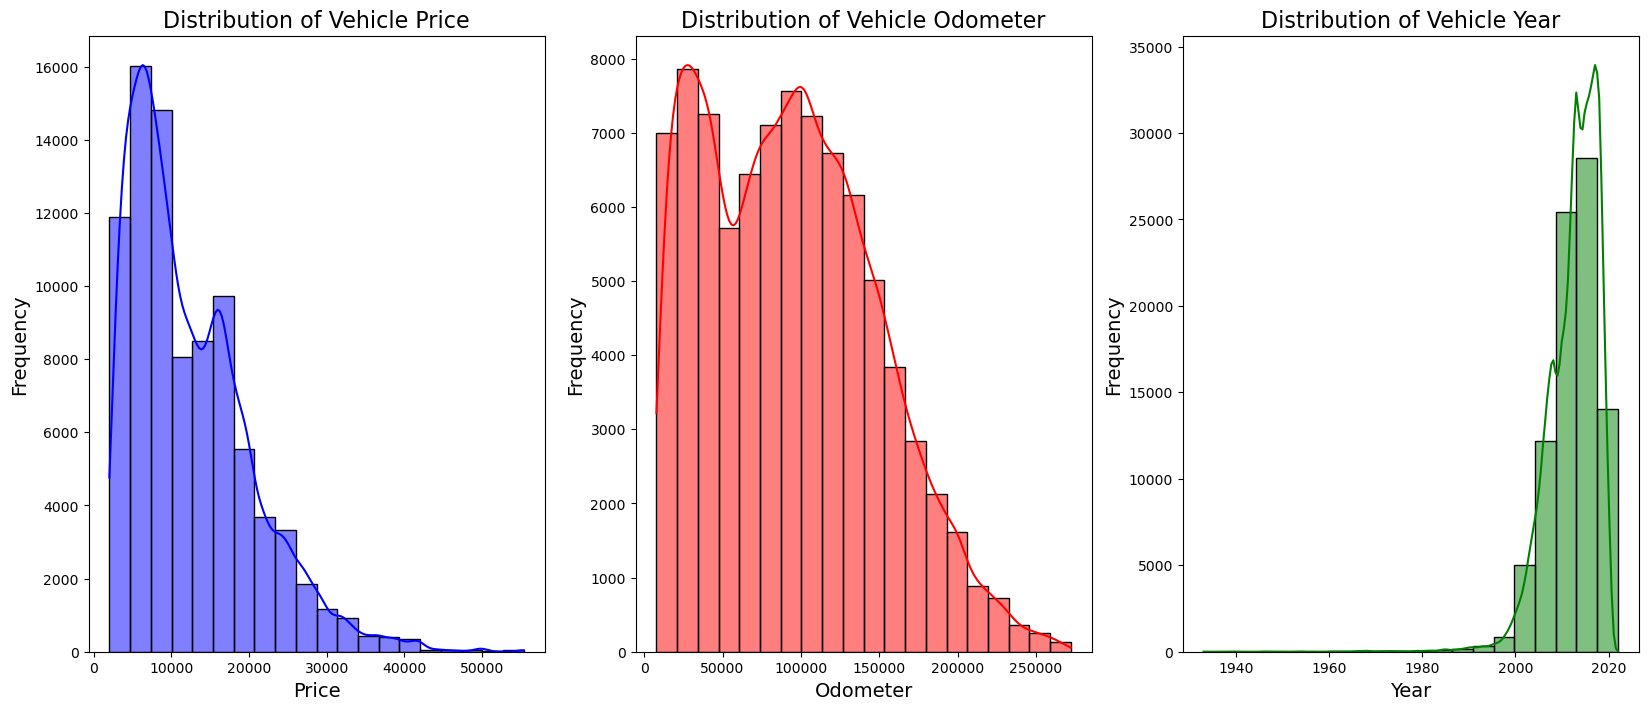

In [98]:
# plotting the distribution of the price, odometer and year columns

plt.figure(figsize = (20, 8))

plt.subplot(1, 3, 1)
sns.histplot(data.price, bins = 20, kde = True, color = 'blue')
plt.title('Distribution of Vehicle Price', fontsize = 16)
plt.xlabel('Price', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.subplot(1, 3, 2)
sns.histplot(data.odometer, bins = 20, kde = True, color = 'red')
plt.title('Distribution of Vehicle Odometer', fontsize = 16)
plt.xlabel('Odometer', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.subplot(1, 3, 3)
sns.histplot(data.year, bins = 20, kde = True, color = 'green')
plt.title('Distribution of Vehicle Year', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.show()
plt.close()

In [99]:
# We can see that the price and odometer columns are right skewed and year values is left skewed. 
# We will apply quantile transformation to these columns to make them normally distributed.

# Quantile transformation effectively handles skewed data by transforming the distributions of the price, odometer, 
# and year features to be more normal-like. This is done by mapping the data to a normal distribution.

skewness = data[['price', 'odometer', 'year']].apply(lambda x: skew(x))
skewness

price       1.135516
odometer    0.427435
year       -2.074534
dtype: float64

In [100]:
#  We do not see much data before 2000. We will remove the records that are below year 1990
data = data[data['year'] >= 2000]

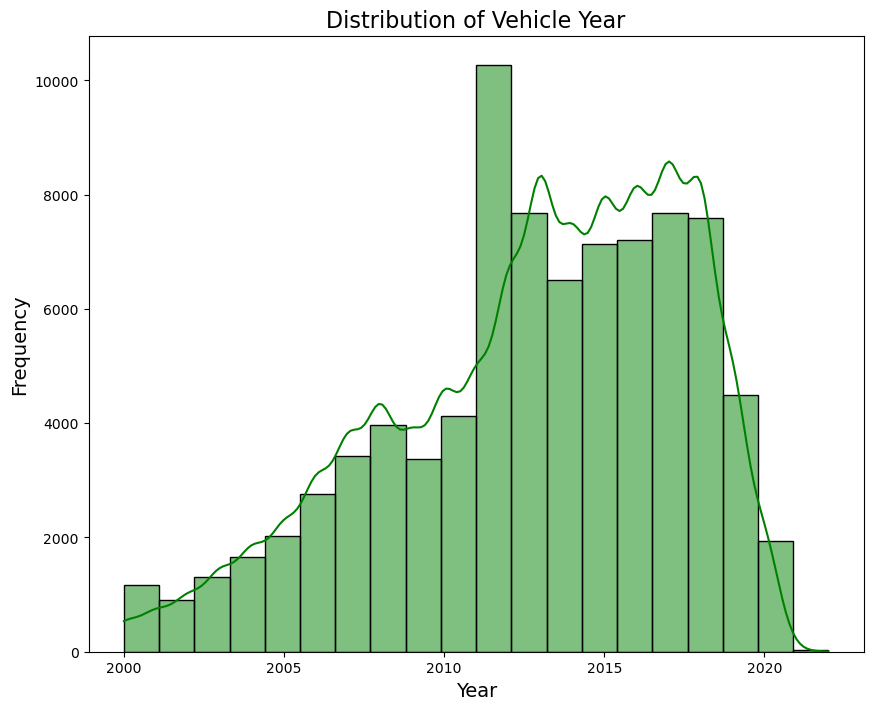

In [101]:
plt.figure(figsize = (10, 8))
sns.histplot(data.year, bins = 20, kde = True, color = 'green')
plt.title('Distribution of Vehicle Year', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.show()
plt.close()

In [102]:
skewness = skew(data.year)
skewness

-0.6071769880031013

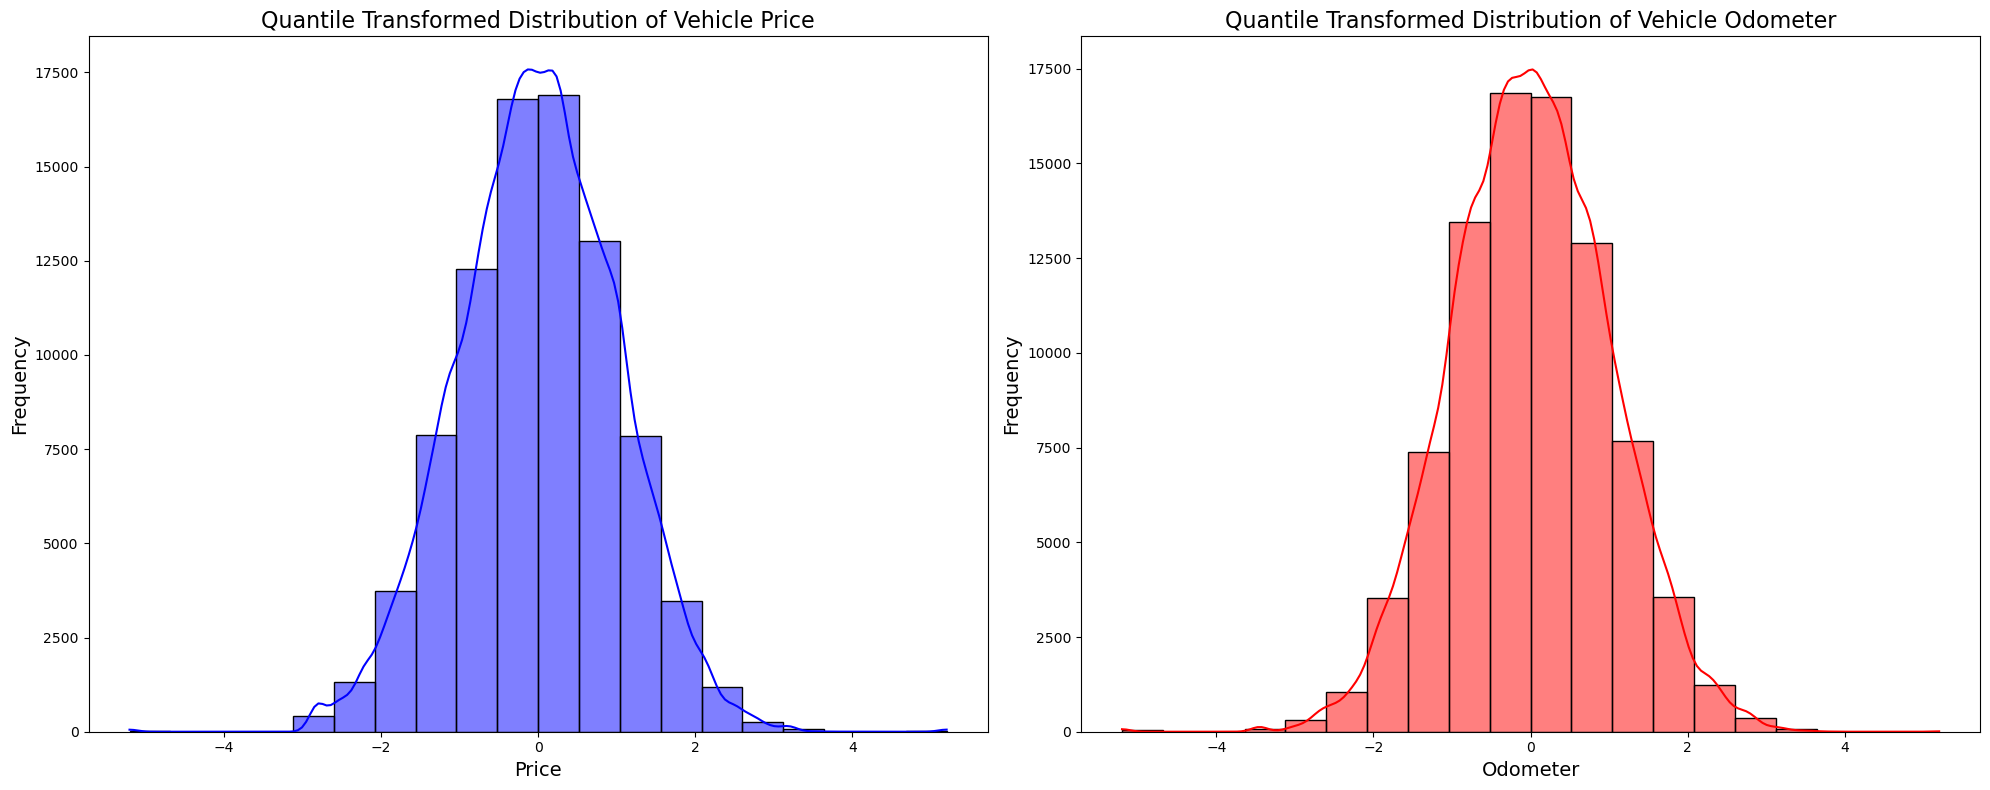

In [103]:
# Initialize the QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution = 'normal', random_state = 42) # can either be normal or uniform

# Apply quantile transformation

data['price_quantile'] = quantile_transformer.fit_transform(data[['price']])
data['odometer_quantile'] = quantile_transformer.fit_transform(data[['odometer']])
# data['year_quantile'] = quantile_transformer.fit_transform(data[['year']])

# Visualize the distributions

plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
sns.histplot(data.price_quantile, bins = 20, kde = True, color = 'blue')
plt.title('Quantile Transformed Distribution of Vehicle Price', fontsize = 16)
plt.xlabel('Price', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.subplot(1, 2, 2)
sns.histplot(data.odometer_quantile, bins = 20, kde = True, color = 'red')
plt.title('Quantile Transformed Distribution of Vehicle Odometer', fontsize = 16)
plt.xlabel('Odometer', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

# plt.subplot(1, 3, 3)
# sns.histplot(data.year_quantile, bins = 20, kde = True, color = 'green')
# plt.title('Quantile Transformed Distribution of Vehicle Year', fontsize = 16)
# plt.xlabel('Year', fontsize = 14)
# plt.ylabel('Frequency', fontsize = 14)

plt.tight_layout()
plt.show()
plt.close()

In [104]:
skewness = data[['price_quantile', 'odometer_quantile']].apply(lambda x: skew(x))
skewness

price_quantile      -0.033126
odometer_quantile   -0.015591
dtype: float64

In [31]:
# Clipping extreme values preventing extreme outliers from distorting distribution.
# In standard normal distributions, values beyond ±2 are very rare (4.56% of data). Clipping at ±2 is a reasonable choice.
#  Extreme values are artificially introduced by the quantile transformation

# data[["year_quantile", "odometer_quantile", "price_quantile"]] = data[["year_quantile", "odometer_quantile", "price_quantile"]].clip(-2, 2)


In [105]:
# We can see that we have transformed the odometer, price and year column and skewness has been handled.
# Now we will drop the original columns and keep the quantile transformed columns.

data.drop(columns = ['price', 'odometer'], inplace = True)


In [33]:
data.head()

,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,price_quantile,odometer_quantile
27,auburn,2014.0,gmc,sierra,good,8 cylinders,gas,clean,other,unknown,unknown,pickup,white,al,1.079690,-0.464621
28,auburn,2010.0,chevrolet,silverado,good,8 cylinders,gas,clean,other,unknown,unknown,pickup,blue,al,0.419741,-0.287654
29,auburn,2020.0,chevrolet,silverado,good,8 cylinders,gas,clean,other,unknown,unknown,pickup,red,al,1.509656,-1.418019
30,auburn,2017.0,toyota,tundra,good,8 cylinders,gas,clean,other,unknown,unknown,pickup,red,al,0.935852,-0.728925
31,auburn,2013.0,ford,f150,excellent,6 cylinders,gas,clean,automatic,rwd,full-size,truck,black,al,-0.048948,0.558392


<Axes: >

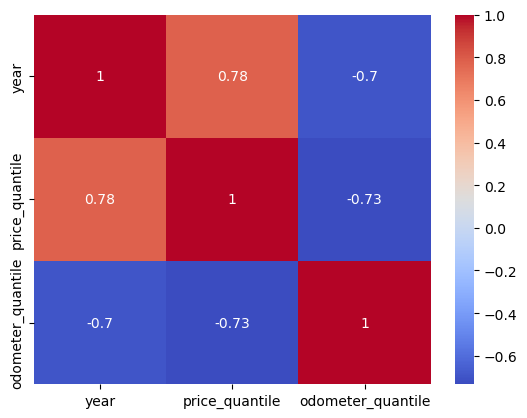

In [106]:
# We will look at the correlation of numerical features

correlation = data.corr(numeric_only = True)
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

In [93]:
# From the correlation plot, we can see that price is positively correlated with year and negatively correlated with odometer.

In [94]:
# Now we will transform the categorical columns

In [107]:
# Custom Transformer: Frequency Encoding

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Custom transformer for frequency encoding.
    
    Each category is replaced with the frequency of its occurrence in the dataset.
    """
    def __init__(self):
        self.freq_maps = {}

    def fit(self, X, y = None):
        """Compute the frequency of each category."""
        for col in X.columns:
            self.freq_maps[col] = X[col].value_counts()
        return self

    def transform(self, X):
        """Apply frequency encoding to transform categorical variables."""
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map(self.freq_maps[col]).fillna(0)  # Handle unseen categories with 0
        return X_transformed


# Custom Transformer: Ordinal Encoding

class OrdinalEncoder(BaseEstimator, TransformerMixin):
    """
    Custom transformer for ordinal encoding based on a predefined mapping.
    """
    def __init__(self, mapping):
        self.mapping = mapping

    def fit(self, X, y = None):
        """No fitting required as mapping is predefined."""
        return self

    def transform(self, X):
        """Apply ordinal encoding by replacing values based on the mapping."""
        return X.replace(self.mapping)


# Feature Groups

categorical_features = ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size']
frequency_features = ['region', 'manufacturer', 'model', 'type', 'paint_color', 'state']
ordinal_features = ['condition']
pass_through_features = ['odometer_quantile', 'price_quantile', 'year']


# Defining Transformers

# Drop first category to avoid multicollinearity, but it does not guarantee the complete absence of multicollinearity

onehot_transformer = OneHotEncoder(drop = 'first', sparse_output = False)
frequency_transformer = FrequencyEncoder()
ordinal_transformer = OrdinalEncoder(mapping = {
    'new': 6,
    'like new': 5,
    'excellent': 4,
    'good': 3,
    'fair': 2,
    'salvage': 1,
    'unknown': 0
})


# Column Transformer: Applying All Transformations

preprocessor = ColumnTransformer(
    transformers = [
        ('onehot', onehot_transformer, categorical_features),
        ('frequency', frequency_transformer, frequency_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('pass', 'passthrough', pass_through_features)  # Pass-through for numerical features
    ]
)


# Applying transformation

data_transformed = preprocessor.fit_transform(data)

# Extracting transformed columns names

encoded_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features)
transformed_columns = list(encoded_columns) + frequency_features + ordinal_features + pass_through_features

# Convert the transformed data back to a DataFrame

data_transformed_df = pd.DataFrame(data_transformed, columns = transformed_columns, index = data.index)

C:\Users\kusha\AppData\Local\Temp\ipykernel_16136\2252915857.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace(self.mapping)


In [96]:
# Now we will scale the features for machine learning model

In [108]:
data_transformed_df.head()

# Columns to exclude from scaling

exclude_columns = ['odometer_quantile', 'price_quantile']
# exclude_columns = []

# Columns to scale

columns_to_scale = data_transformed_df.columns.difference(exclude_columns)


# Initialize the scaler

scaler = StandardScaler()

# Scale the features except the pass-through features

data_transformed_df[columns_to_scale] = scaler.fit_transform(data_transformed_df[columns_to_scale])


# Display the head of the DataFrame

data_transformed_df.head()

,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,cylinders_unknown,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,fuel_unknown,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,title_status_unknown,transmission_manual,transmission_other,transmission_unknown,size_full-size,size_mid-size,size_sub-compact,size_unknown,region,manufacturer,model,type,paint_color,state,condition,odometer_quantile,price_quantile,year
54,-0.004844,-0.053466,-0.878298,-0.097881,-0.526294,-0.100176,-0.0504,1.448814,-0.078869,-2.843326,-0.184487,4.242536,-0.087994,-0.054882,-0.015319,-0.00839,-0.165173,-0.105136,-0.075091,-0.222898,2.419373,-0.059724,-0.368415,-0.42484,-0.111886,0.775035,-1.769845,-1.404915,-0.977205,-0.793601,0.505427,-0.82203,0.310275,-1.964387,1.926403,1.339821
59,-0.004844,-0.053466,-0.878298,-0.097881,1.900078,-0.100176,-0.0504,-0.690220,-0.078869,0.351701,-0.184487,-0.235708,-0.087994,-0.054882,-0.015319,-0.00839,-0.165173,-0.105136,-0.075091,-0.222898,-0.413330,-0.059724,2.714330,-0.42484,-0.111886,-1.290264,-1.769845,0.949556,0.146394,-1.142791,0.477794,-0.82203,0.877422,0.069056,0.349483,-0.173097
74,-0.004844,-0.053466,-0.878298,-0.097881,-0.526294,-0.100176,-0.0504,1.448814,-0.078869,0.351701,-0.184487,-0.235708,-0.087994,-0.054882,-0.015319,-0.00839,-0.165173,-0.105136,-0.075091,-0.222898,2.419373,-0.059724,-0.368415,-0.42484,-0.111886,0.775035,-1.769845,0.949556,2.349022,-1.153384,0.477794,-0.82203,0.310275,-2.244265,1.550085,1.555952
75,-0.004844,-0.053466,-0.878298,-0.097881,-0.526294,-0.100176,-0.0504,1.448814,-0.078869,0.351701,-0.184487,-0.235708,-0.087994,-0.054882,-0.015319,-0.00839,-0.165173,-0.105136,-0.075091,-0.222898,2.419373,-0.059724,-0.368415,-0.42484,-0.111886,0.775035,-1.769845,0.949556,2.349022,1.082997,0.938173,-0.82203,0.310275,-1.088723,0.858910,1.123689
77,-0.004844,-0.053466,-0.878298,-0.097881,-0.526294,-0.100176,-0.0504,1.448814,-0.078869,0.351701,-0.184487,-0.235708,-0.087994,-0.054882,-0.015319,-0.00839,-0.165173,-0.105136,-0.075091,-0.222898,2.419373,-0.059724,-0.368415,-0.42484,-0.111886,0.775035,-1.769845,0.949556,2.349022,1.082997,0.684106,-0.82203,0.310275,-5.199338,1.132898,1.123689


In [98]:
# The final dataset is ready for modeling. We will assign the final data to dataset variable and reset the index of the dataset

In [109]:
dataset = data_transformed_df.reset_index(drop = True)

In [100]:
# We will check whether the dataset is sparse or not since sparse matrix is not good for modeling.
# Algorithms like linear regression, kNN, and tree-based models may struggle with sparse data, leading to poor generalization and biased predictions.
# If too many features have zero values, the model may fail to capture meaningful patterns.

In [111]:
# Check if the resulting DataFrame is sparse

is_sparse = any(isinstance(dtype, pd.SparseDtype) for dtype in dataset.dtypes)
print(f"Is the DataFrame sparse? {is_sparse}")

Is the DataFrame sparse? False


In [102]:
# Multicollinearity

# High correlation between features can make it difficult to interpret which feature truly influences the target variable.

# In Linear Regression, Logistic Regression, and other parametric models, multicollinearity leads to large standard errors and unreliable coefficients.
# Highly correlated variables contribute redundant information, increasing model complexity without adding value. 
# Removing them can help prevent overfitting and improve generalization.

In [112]:
# Check for multicollienarity

# Multicollinearity Check using Variance Inflation Factor (VIF)

data = dataset.drop(columns = 'price_quantile')
vif_data = pd.DataFrame()
vif_data["Feature"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

print("\nVariance Inflation Factor (VIF) for Each Feature:")
print(vif_data)


Variance Inflation Factor (VIF) for Each Feature:
                    Feature          VIF
0    cylinders_12 cylinders     1.222986
1     cylinders_3 cylinders    27.960931
2     cylinders_4 cylinders  2331.744104
3     cylinders_5 cylinders    90.121275
4     cylinders_6 cylinders  1610.702384
5     cylinders_8 cylinders    94.210605
6           cylinders_other    25.020817
7         cylinders_unknown  2073.451479
8             fuel_electric     1.639770
9                  fuel_gas     9.426094
10              fuel_hybrid     4.012099
11               fuel_other     5.712411
12             fuel_unknown     1.804477
13        title_status_lien     1.006345
14     title_status_missing     1.000698
15  title_status_parts only     1.000387
16     title_status_rebuilt     1.030346
17     title_status_salvage     1.007508
18     title_status_unknown     1.074534
19      transmission_manual     1.058492
20       transmission_other     1.622301
21     transmission_unknown     1.018176
22    

In [104]:
# The Variance Inflation Factor (VIF) results you provided suggest the following:

# Interpreting VIF Values
# VIF of 1: Indicates that the feature is not correlated with other features. It does not suffer from multicollinearity.
# VIF between 1 and 5: Generally considered low multicollinearity, meaning the feature is reasonably independent.
# VIF between 5 and 10: Indicates moderate multicollinearity, meaning the feature is somewhat correlated with other features.
# VIF above 10: Suggests high multicollinearity, meaning the feature is highly correlated with others and should likely be considered for removal or further investigation.

# Remove or Combine High VIF Features:
# Consider removing or combining the highly collinear features (cylinders_4 cylinders, cylinders_6 cylinders, cylinders_8 cylinders, and cylinders_unknown) to reduce multicollinearity.

# We can see that the features cylinders_4 cylinders, cylinders_6 cylinders, cylinders_8 cylinders, and cylinders_unknown have very high VIF values as well as size_unknown, indicating multicollinearity issues.

# To handle this issue, we will drop one of the cylinder_unknown and size_unknown features
# retrain the model and check the VIF values again.

In [113]:
dataset.drop(columns = ['size_unknown', 'cylinders_unknown'], inplace = True)  # Features

In [114]:
# Now, we will check for multicollinearity again to verify that we successfully handled this issue

# Check for multicollienarity

# Multicollinearity Check using Variance Inflation Factor (VIF)

data = dataset.drop(columns = 'price_quantile')
vif_data = pd.DataFrame()
vif_data["Feature"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

print("\nVariance Inflation Factor (VIF) for Each Feature:")
print(vif_data)


Variance Inflation Factor (VIF) for Each Feature:
                    Feature       VIF
0    cylinders_12 cylinders  1.000946
1     cylinders_3 cylinders  1.015485
2     cylinders_4 cylinders  1.964468
3     cylinders_5 cylinders  1.057144
4     cylinders_6 cylinders  1.753609
5     cylinders_8 cylinders  1.101475
6           cylinders_other  1.057453
7             fuel_electric  1.639225
8                  fuel_gas  9.425942
9               fuel_hybrid  4.011871
10               fuel_other  5.712370
11             fuel_unknown  1.804134
12        title_status_lien  1.006231
13     title_status_missing  1.000679
14  title_status_parts only  1.000379
15     title_status_rebuilt  1.030238
16     title_status_salvage  1.007301
17     title_status_unknown  1.074455
18      transmission_manual  1.053633
19       transmission_other  1.606980
20     transmission_unknown  1.017927
21           size_full-size  1.281566
22            size_mid-size  1.229197
23         size_sub-compact  1.025501

In [107]:
# We have successfully handled the multicollinearity issue on the dataset. The dataset is ready for modeling.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [115]:
# Features and Target

X = dataset.drop(columns = ['price_quantile'])  # Features
y = dataset['price_quantile']  # Target variable


# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


# Different Models to Try

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators = 100, max_depth = 10, min_samples_split = 10, n_jobs = -1, random_state = 42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.05, max_depth = 5, random_state = 42),
    "XGBoost": XGBRegressor(n_estimators = 300, learning_rate = 0.05, max_depth = 6, subsample = 0.8, colsample_bytree = 0.8, n_jobs = -1, random_state = 42),
    # "SVR": SVR(C = 1, kernel = 'rbf', epsilon = 0.1)
}


# Training and cross validation

results = []
train_mse_values = []
test_mse_values = []
cv_mse_values = []
model_names = []

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)  # 5-Fold Cross-Validation

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Cross-validation scores (Negative MSE)

    cv_mse = -cross_val_score(model, X_train, y_train, cv = kf, scoring = 'neg_mean_squared_error', n_jobs = -1)
    avg_cv_mse = np.mean(cv_mse)
    
    # Training model on full training set

    model.fit(X_train, y_train)
    
    # Predictions

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Computing Errors

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(test_mse)
    r2 = r2_score(y_test, y_test_pred)

    results.append((name, avg_cv_mse, test_mse, rmse, r2))
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)
    cv_mse_values.append(avg_cv_mse)
    model_names.append(name)

    print(f"{name} - CV MSE: {avg_cv_mse:.4f}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


# Converting results to DataFrame

results_df = pd.DataFrame(results, columns = ['Model', 'CV MSE', 'Test MSE', 'RMSE', 'R2']).sort_values(by = 'Test MSE')


Training Linear Regression...
Linear Regression - CV MSE: 0.2637, Train MSE: 0.2633, Test MSE: 0.2594, RMSE: 0.5093, R²: 0.7450

Training Random Forest...
Random Forest - CV MSE: 0.1699, Train MSE: 0.1480, Test MSE: 0.1697, RMSE: 0.4119, R²: 0.8332

Training Gradient Boosting...
Gradient Boosting - CV MSE: 0.1412, Train MSE: 0.1320, Test MSE: 0.1384, RMSE: 0.3721, R²: 0.8639

Training XGBoost...
XGBoost - CV MSE: 0.1174, Train MSE: 0.1013, Test MSE: 0.1147, RMSE: 0.3386, R²: 0.8873


In [44]:
results_df

,Model,CV MSE,Test MSE,RMSE,R2
3,XGBoost,0.156839,0.152203,0.390132,0.848127
2,Gradient Boosting,0.193689,0.187471,0.432979,0.812935
1,Random Forest,0.230869,0.224799,0.474130,0.775688
0,Linear Regression,0.285540,0.277935,0.527195,0.722668


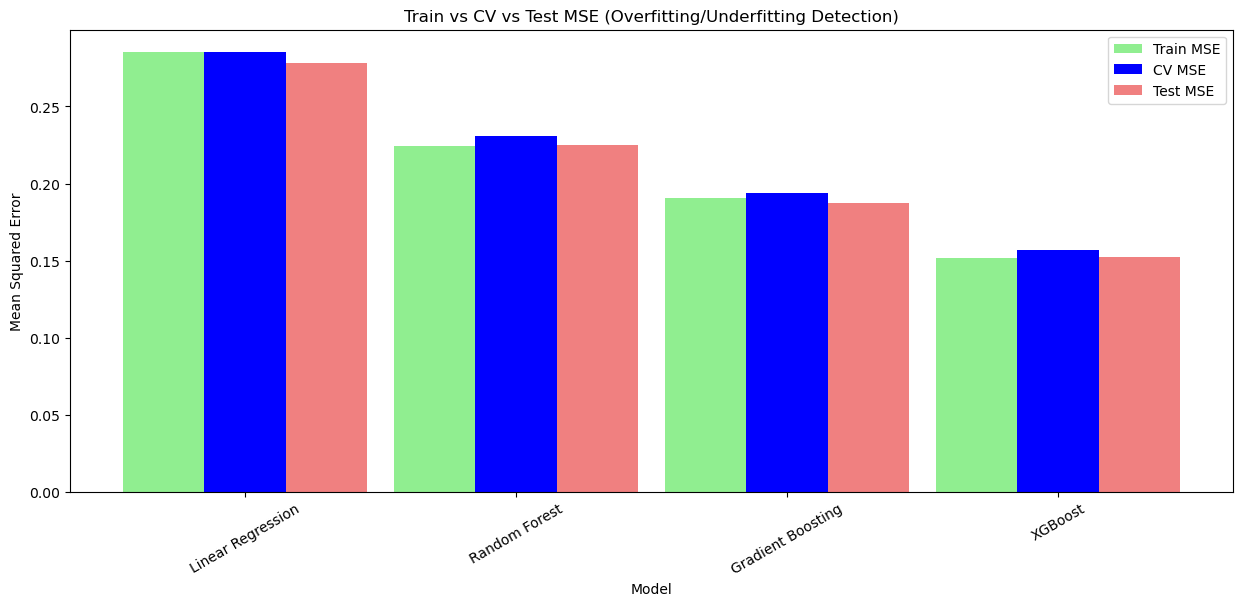

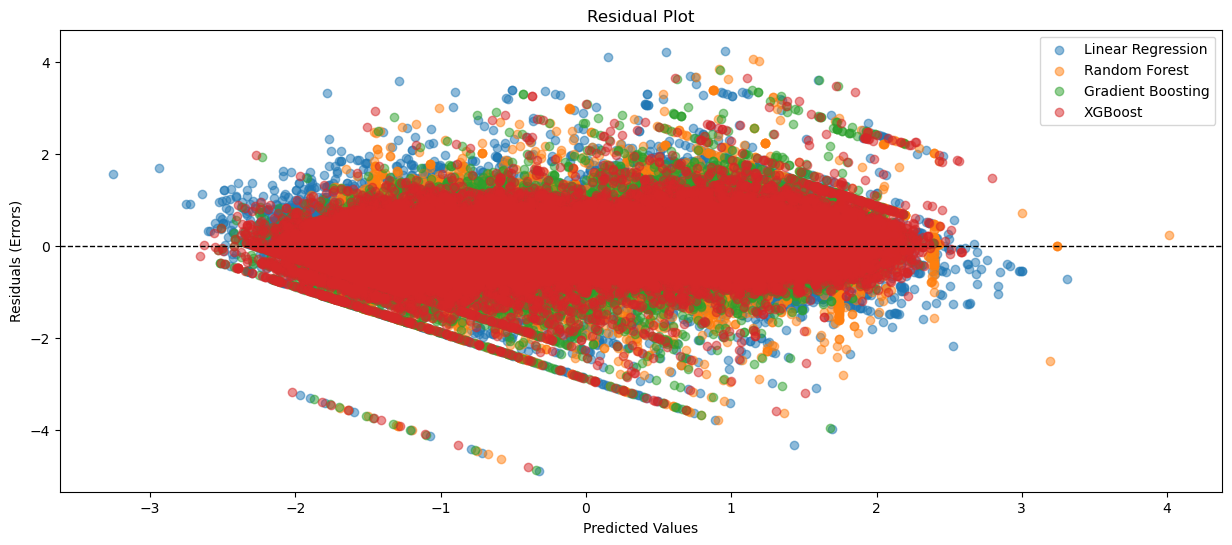

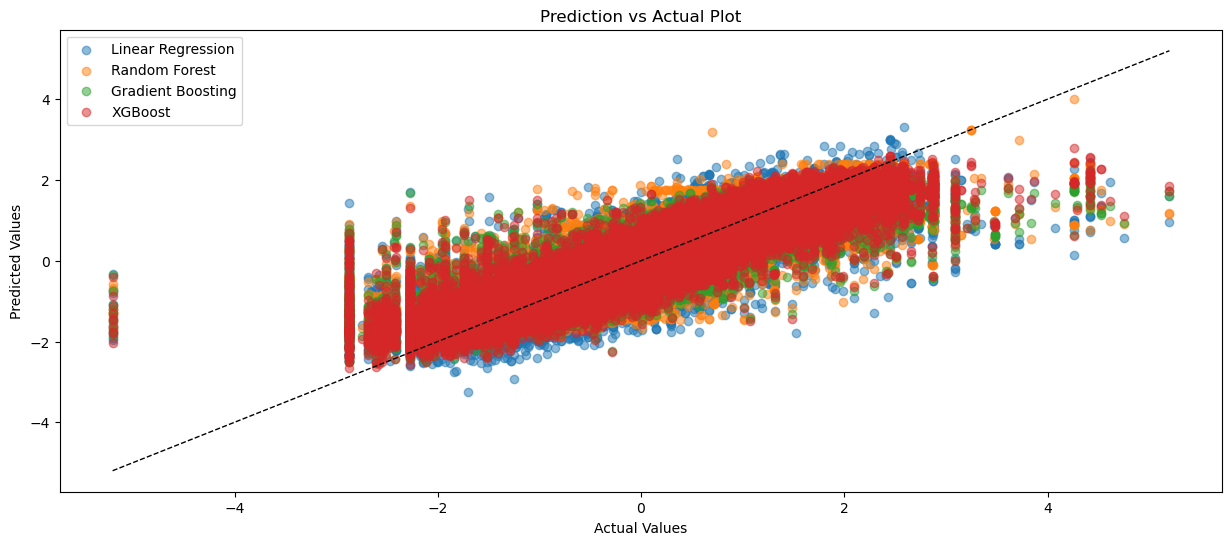

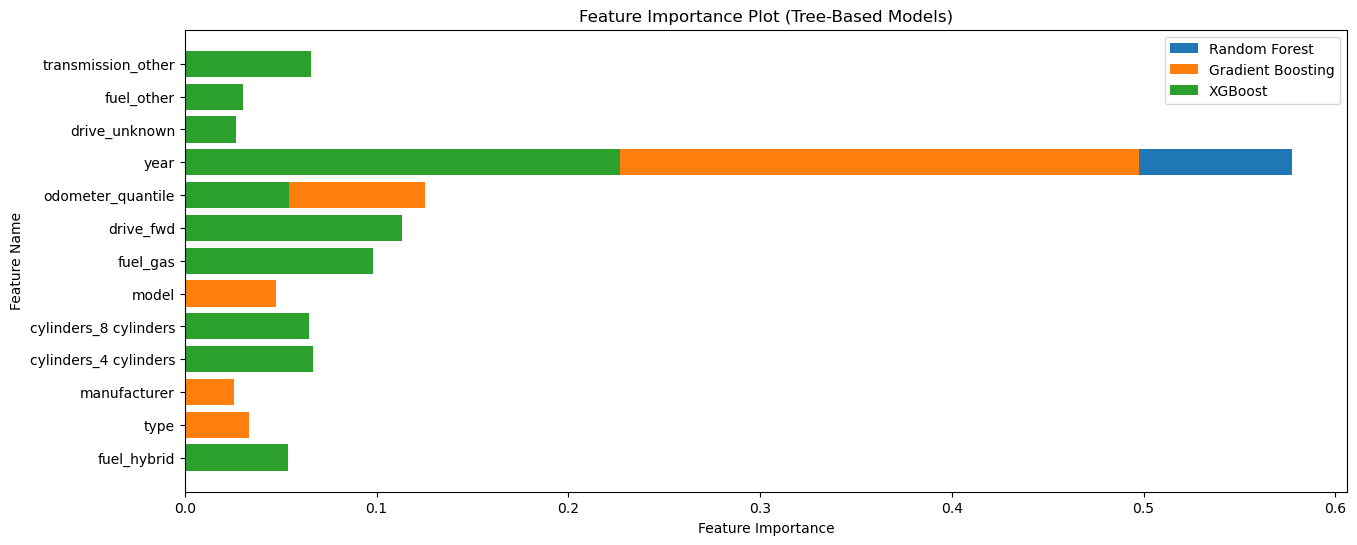

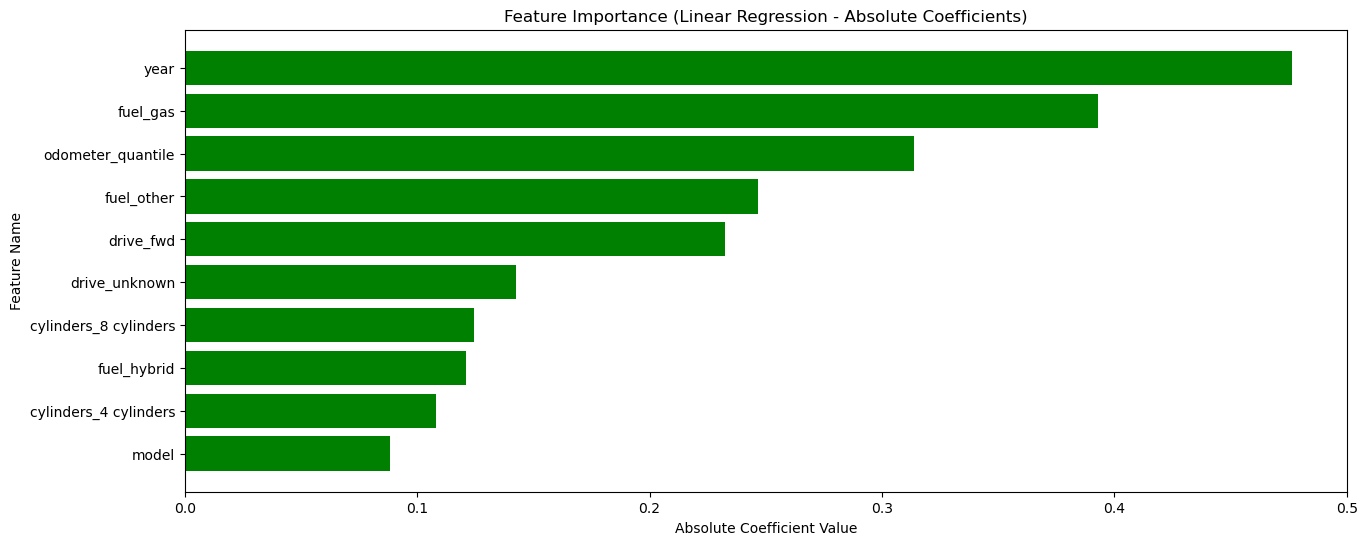

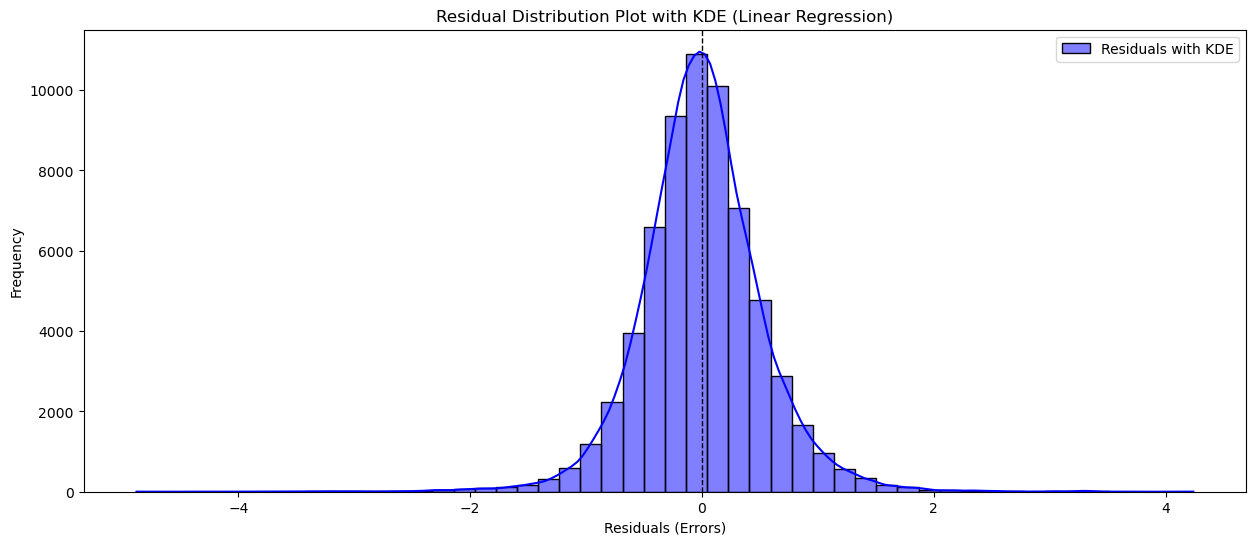

In [43]:
#  Plotting the model to evalute


# Train vs Test vs Cross-Validation MSE

plt.figure(figsize = (15, 6))

x_pos = np.arange(len(model_names))
plt.bar(x_pos - 0.3, train_mse_values, width = 0.3, label = 'Train MSE', color = 'lightgreen')
plt.bar(x_pos, cv_mse_values, width = 0.3, label = 'CV MSE', color = 'blue')
plt.bar(x_pos + 0.3, test_mse_values, width = 0.3, label = 'Test MSE', color = 'lightcoral')
plt.xticks(x_pos, model_names, rotation = 30)
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.title("Train vs CV vs Test MSE (Overfitting/Underfitting Detection)")
plt.legend()
plt.show()


# Residual Plot (Test Set Errors)

plt.figure(figsize = (15, 6))

for name, model in models.items():
    y_test_pred = model.predict(X_test)
    residuals = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha = 0.5, label = name)
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot")
plt.legend()
plt.show()


# Prediction vs Actual Plot (Model Accuracy)

plt.figure(figsize = (15, 6))

for name, model in models.items():
    y_test_pred = model.predict(X_test)
    plt.scatter(y_test, y_test_pred, alpha = 0.5, label = name)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs Actual Plot")
plt.legend()
plt.show()


# Feature Importance Plot (For Tree-Based Models)

plt.figure(figsize=(15, 6))

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        indices = np.argsort(importance)[-10:]  # Top 10 features
        plt.barh(X_train.columns[indices], importance[indices], label = name)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance Plot (Tree-Based Models)")
plt.legend()
plt.show()


# Feature Importance Plot (Linear Regression - Absolute Value of Coefficients)

plt.figure(figsize = (15, 6))

linear_model = models["Linear Regression"]
coefficients = linear_model.coef_
absolute_coefficients = np.abs(coefficients)
indices = np.argsort(absolute_coefficients)[-10:]  # Top 10 most important features based on magnitude
plt.barh(X_train.columns[indices], absolute_coefficients[indices], color = 'green')
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature Name")
plt.title("Feature Importance (Linear Regression - Absolute Coefficients)")
plt.show()


# Residual Distribution Plot (Distribution of Test Set Errors) with KDE for Linear Regression

plt.figure(figsize = (15, 6))

if "Linear Regression" in models:
    linear_model = models["Linear Regression"]
    y_test_pred = linear_model.predict(X_test)
    residuals = y_test - y_test_pred
    
    # Plotting histogram and KDE (Kernel Density Estimate)
    sns.histplot(residuals, kde = True, color = "blue", bins = 50, alpha = 0.5, label = "Residuals with KDE")
    plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 1)
    plt.xlabel("Residuals (Errors)")
    plt.ylabel("Frequency")
    plt.title("Residual Distribution Plot with KDE (Linear Regression)")
    plt.legend()
    plt.show()

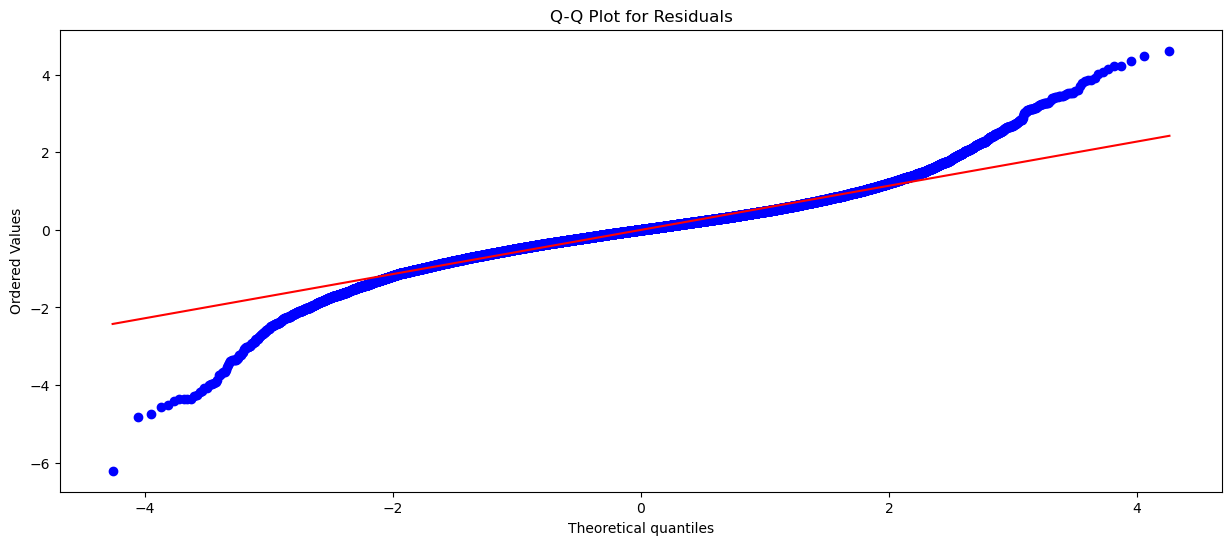

Skewness: 0.0153, Kurtosis: 4.4385
Anderson-Darling Test Statistic: 426.6412
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


In [116]:
#  Further diagnosing Linear Regression Model

y_test_pred = linear_model.predict(X_test)
residuals = y_test - y_test_pred


# Q-Q Plot

plt.figure(figsize=(15, 6))

stats.probplot(residuals, dist = "norm", plot = plt)
plt.title("Q-Q Plot for Residuals")
plt.show()


# Skewness and Kurtosis

skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)

print(f"Skewness: {skewness:.4f}, Kurtosis: {kurtosis:.4f}")


# 3. Anderson-Darling Test for Normality

anderson_result = stats.anderson(residuals, dist = 'norm')
print(f"Anderson-Darling Test Statistic: {anderson_result.statistic:.4f}")
print(f"Critical Values: {anderson_result.critical_values}")
print(f"Significance Levels: {anderson_result.significance_level}")


The normality test on the residuals from the linear regression model indicates some issues. While the skewness is close to 0 (indicating symmetry), the kurtosis value (4.44) suggests heavy tails, meaning the distribution has more extreme values than a normal distribution. The Anderson-Darling test rejects the null hypothesis of normality, and the Q-Q plot shows significant deviations in the upper and lower tails, confirming the non-normality.

This suggests the residuals are not normally distributed.

In [ ]:
# Fit the model

model = sm.OLS(y_train, sm.add_constant(X_train))  # OLS for training data
results = model.fit()

# Perform Breusch-Pagan test

test_result = sms.het_breuschpagan(results.resid, results.model.exog)
bp_test_statistic, bp_p_value = test_result[0], test_result[1]
print(f"Breusch-Pagan Test Statistic: {bp_test_statistic}, p-value: {bp_p_value}")


Breusch-Pagan Test Statistic: 11299.601087746589, p-value: 0.0


The Breusch-Pagan test results indicate a very small p-value (0.0) and a large test statistic (11299.6). This suggests that there is strong evidence against the null hypothesis of homoscedasticity (constant variance of residuals). The model suffers from heteroscedasticity, the variance of the residuals changes as the predicted values change.

In [ ]:
# Perform White test for heteroscedasticity

white_test_statistic, white_p_value, _, _ = het_white(results.resid, results.model.exog)
print(f"White Test Statistic: {white_test_statistic}, p-value: {white_p_value}")

White Test Statistic: 29931.943747883204, p-value: 0.0


The White test results also show a very small p-value (0.0) and a high test statistic (29931.94), confirming the presence of heteroscedasticity in linear regression model. Similar to the Breusch-Pagan test, the White test suggests that the residuals' variance is not constant, which can lead to inefficient estimates and biased inferences.

Random Forest, Gradient Boosting, and XGBoost are non-linear models and generally do not make assumptions about homoscedasticity (constant variance of the residuals). So, we 
will conduct feature selection and search the space to find better hyperparameters than the ones randomly selected above and discard Linear Regression Model.

In [ ]:
# Now, we will conduct feature selection using Sequential Feature Selector


In [71]:
sfs = SequentialFeatureSelector(
    model,
    # n_features_to_select=15,  # Selecting 15 features directly since sfs on 36 features is computationally expensive
    direction='forward',
    cv=2,
    n_jobs=-1,
    tol=0.0001
)
sfs.fit(X_train, y_train)
selected_features = X_train.columns[sfs.get_support()]
print(f"Selected Features: {list(selected_features)}")

KeyboardInterrupt: 

In [ ]:
# segment the dataset by categorical variables and try to fit the models.
# Streamline the process with Pipeline

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.